In [1]:
import sys, os
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from sqlalchemy import types, create_engine
from datetime import date, timedelta
from datetime import datetime
import time
import re
import pylab as py
from matplotlib import gridspec
import matplotlib.dates as md
from sklearn.model_selection import LeaveOneOut
os.environ['PROJ_LIB'] = '/home/ehsan/anaconda3/share/proj'
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Import modules
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def metrics(y1, y2):
  '''
  y1 and y2 are two series of the same size

  This function outputs the MAE, RMSE and R^2 
  of the cross evaluated series.

  '''
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################

In [4]:
df = pd.read_csv("Tmin_Data_Not_Filled.txt", encoding = "ISO-8859-1", engine='python')

In [5]:
meta_columns = ['SKN', 'Station.Name', 'Sta..ID', 'Island', 'Network', 'LON', 'LAT', 'Elev.']
Temp_columns = df.columns[8:]
Temp_columns

Index(['X1990.01.01', 'X1990.01.02', 'X1990.01.03', 'X1990.01.04',
       'X1990.01.05', 'X1990.01.06', 'X1990.01.07', 'X1990.01.08',
       'X1990.01.09', 'X1990.01.10',
       ...
       'X2014.12.22', 'X2014.12.23', 'X2014.12.24', 'X2014.12.25',
       'X2014.12.26', 'X2014.12.27', 'X2014.12.28', 'X2014.12.29',
       'X2014.12.30', 'X2014.12.31'],
      dtype='object', length=9131)

In [6]:
df2 = df[meta_columns]
df2 = df2.set_index("SKN")

print(len(df2))

df2.head()

142


,Station.Name,Sta..ID,Island,Network,LON,LAT,Elev.
SKN,,,,,,,
337.2,Puu o Pele,CN1,Ma,CraterNet,-156.212261,20.718443,2281.0
337.3,Lava lake,CN2,Ma,CraterNet,-156.188007,20.717807,2258.0
337.6,Puu Nole,CN3,Ma,CraterNet,-156.224485,20.709651,2430.0
337.4,Silversword loop,CN4,Ma,CraterNet,-156.205387,20.731704,2185.0
337.0,south rim,CN5,Ma,CraterNet,-156.239400,20.714563,2704.0


In [7]:
df2.groupby("Island").count()

,Station.Name,Sta..ID,Network,LON,LAT,Elev.
Island,,,,,,
BI,32,32,32,32,32,32
Bi,19,19,19,19,19,19
Ka,14,14,14,14,14,14
Ko,5,5,5,5,5,5
La,2,2,2,2,2,2
Ma,31,31,31,31,31,31
Mo,6,6,6,6,6,6
Oa,33,33,33,33,33,33


In [8]:
df2 = df2[(df2.Island=='BI')|(df2.Island=='Bi')]
# df2 = df2[(df2.Island=='Ma')]
print(len(df2))

df2.head()

51


,Station.Name,Sta..ID,Island,Network,LON,LAT,Elev.
SKN,,,,,,,
87.9,IPIF,HE281,BI,HECO,-155.09540,19.69748,111.0
132.3,Spencer,HE282,BI,HECO,-155.25014,19.96358,454.0
127.5,Laupahoehoe,HE283,BI,HECO,-155.29129,19.93217,1145.0
128.1,Hakalau,HE284,BI,HECO,-155.30797,19.83873,1665.0
93.9,KiholoBay,HE285,BI,HECO,-155.92470,19.85497,2.0


In [9]:
df1 = df[["SKN"]+list(Temp_columns)].T

new_header = df1.iloc[0]
df1 = df1[1:] 
df1.columns = new_header 

df1.index = pd.to_datetime([x.split('X')[1] for x in df1.index.values])
df1.index.name = 'Date'

df1 = df1[list(df2.index.values)]

# df1 = df1.resample('1M').mean()

print(len(df1))
df1.tail(5)

9131


SKN,87.90,132.30,127.50,128.10,93.90,69.25,93.00,54.80,54.90,39.00,...,48.00,101.10,107.40,75.10,108.00,99.00,93.12,94.50,113.20,95.60
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-27,15.495,15.432,10.6820,3.9784,NaN,16.279,12.2340,NaN,11.492,3.6,...,15.000,11.1110,NaN,NaN,6.463750,4.4444,12.678414,NaN,NaN,NaN
2014-12-28,14.032,14.157,9.9744,2.1858,NaN,15.809,8.1888,NaN,8.789,4.7,...,13.333,9.4444,NaN,NaN,5.504413,5.0000,9.479259,NaN,NaN,NaN
2014-12-29,15.671,14.048,9.6424,4.7246,NaN,17.922,9.6739,NaN,8.372,2.9,...,11.667,9.4444,NaN,NaN,6.863090,5.0000,10.850607,NaN,NaN,NaN
2014-12-30,15.804,15.775,10.4290,1.5840,NaN,17.883,13.9860,NaN,9.052,3.1,...,11.667,12.2220,NaN,NaN,5.182351,8.8889,14.506220,NaN,NaN,NaN
2014-12-31,15.900,14.286,11.7290,4.8118,NaN,15.990,14.1650,NaN,11.356,2.7,...,14.444,10.0000,NaN,NaN,6.909756,9.4444,14.048857,NaN,NaN,NaN


In [10]:
df3 = df2[["LON", "LAT", "Elev."]].T
df3 = df3[list(df2.index.values)]
df3

SKN,87.90,132.30,127.50,128.10,93.90,69.25,93.00,54.80,54.90,39.00,...,48.00,101.10,107.40,75.10,108.00,99.00,93.12,94.50,113.20,95.60
LON,-155.09540,-155.25014,-155.29129,-155.30797,-155.92470,-155.99582,-155.85062,-155.238402,-155.214969,-155.5763,...,-155.292,-155.679,-155.545,-155.708,-155.627,-155.702,-155.770,-155.842,-155.437,-155.794
LAT,19.69748,19.96358,19.93217,19.83873,19.85497,19.73756,19.80256,19.415214,19.478407,19.5362,...,19.318,19.902,19.683,19.667,19.746,19.772,19.833,19.773,19.907,19.924
Elev.,111.00000,454.00000,1145.00000,1665.00000,2.00000,297.00000,636.00000,1202.000000,1042.000000,3397.0000,...,847.000,1026.000,1960.000,1641.000,1756.000,1308.000,831.000,709.000,2165.000,298.000


<ipython-input-11-1c922e9583bb>:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')
<ipython-input-11-1c922e9583bb>:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
<ipython-input-11-1c922e9583bb>:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


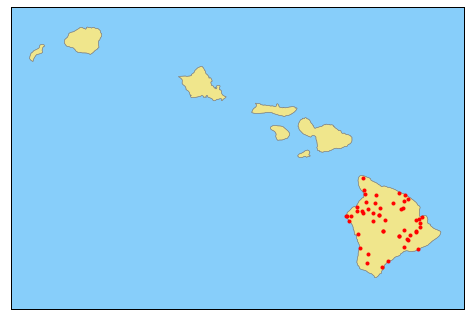

In [11]:
fig=plt.figure(figsize=(7,7))
ax = fig.add_axes([0.05,0.05,0.9,0.9])

map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')

shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


map.drawmapboundary(fill_color='lightskyblue')

for lon, lat in list(zip(df2.LON.values, df2.LAT.values)):
    
    x, y = map(lon, lat)
    map.plot(x, y, marker='o',color='red',markersize=3)

for nshape, shapedict in enumerate(map.states_info):
     if shapedict['NAME'] in ['Hawaii']:
         seg = map.states[int(shapedict['SHAPENUM'] - 1)]
         poly = Polygon(seg, facecolor='khaki', edgecolor='gray', linewidth=.45)
         ax.add_patch(poly)

# ax.annotate("Oahu",(-158.27,21.8), fontsize=12)
# ax.annotate("Maui",(-156.28,20.98), fontsize=12)
# ax.annotate("Hawaii",(-155.8,19.54), fontsize=12)
# ax.annotate("Molokai",(-157.23,21.31), fontsize=12)
# ax.annotate("Kauai",(-159.7,21.7), fontsize=12)
# ax.annotate("Lanai",(-157.55,20.74), fontsize=12)

# ax.annotate("HAWAII",(-160.24,18.75), fontsize=16)

In [12]:
df_station =  df3.T
df_station = df_station.join(df1.T, how='left')

print(len(df_station))

df_station.tail()

51


,LON,LAT,Elev.,1990-01-01 00:00:00,1990-01-02 00:00:00,1990-01-03 00:00:00,1990-01-04 00:00:00,1990-01-05 00:00:00,1990-01-06 00:00:00,1990-01-07 00:00:00,...,2014-12-22 00:00:00,2014-12-23 00:00:00,2014-12-24 00:00:00,2014-12-25 00:00:00,2014-12-26 00:00:00,2014-12-27 00:00:00,2014-12-28 00:00:00,2014-12-29 00:00:00,2014-12-30 00:00:00,2014-12-31 00:00:00
SKN,,,,,,,,,,,,,,,,,,,,,
99.00,-155.702,19.772,1308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.888900,12.778000,10.649859,7.777800,5.555600,4.444400,5.000000,5.000000,8.88890,9.444400
93.12,-155.770,19.833,831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.877486,15.420123,14.048857,13.592317,12.221051,12.678414,9.479259,10.850607,14.50622,14.048857
94.50,-155.842,19.773,709.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113.20,-155.437,19.907,2165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95.60,-155.794,19.924,298.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
Date = pd.to_datetime("2010-05-15")

data = df_station[["LON", "LAT", "Elev.", Date]].dropna()

print(len(data))

data.head()

2021-01-29 01:53:31,710 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


25


,LON,LAT,Elev.,2010-05-15 00:00:00
SKN,,,,
87.90,-155.09540,19.69748,111.0,16.600
132.30,-155.25014,19.96358,454.0,16.560
127.50,-155.29129,19.93217,1145.0,12.250
128.10,-155.30797,19.83873,1665.0,6.031
69.25,-155.99582,19.73756,297.0,18.560


In [14]:
X = data[["LON", "LAT", "Elev."]].values

y = data[Date].values

In [15]:
from scipy.optimize import minimize
import george
from george import kernels
from sklearn.model_selection import KFold

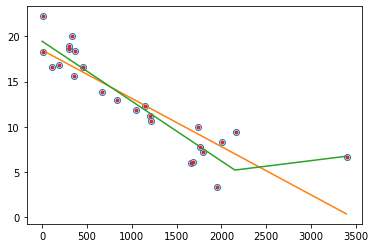

In [16]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a*x+b

def bilinear(x, a, b, c):
    
    left  = a*x+b
    right = c*(x-2150) + (a*2150+b) 
    
    try:
        y = np.asarray([left[i] if x[i]<=2150 else right[i] for i in range(len(x))])
        return y
    except:
        if x<=2150:
            return left
        else:
            return right

plt.plot(X[:,2], y, 'o', mfc='white')




u = np.arange(np.round(np.max(X[:,2])))

fit, cov = curve_fit(linear, X[:,2], y, sigma=y*0+1)
v1 = linear(u, fit[0], fit[1])

fit, cov = curve_fit(bilinear, X[:,2], y, sigma=y*0+1)



model = bilinear(X[:,2], fit[0], fit[1], fit[2])

indx, = np.where(np.abs(model-y)<3)

fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)


model = bilinear(X[:,2], fit[0], fit[1], fit[2])

indx, = np.where(np.abs(model-y)<5)

fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)

plt.plot(u, v1)

v2 = bilinear(u, fit[0], fit[1], fit[2])
plt.plot(u, v2)

plt.plot(X[:,2][indx], y[indx], '.')

In [17]:
# indx = range(len(y))

In [18]:
def nll_fn2(X, y):
    
    

    def step(theta):
        
#         kf = KFold(n_splits=3)
        loo = LeaveOneOut()
        XI2 = 0
        
#         for train_index, test_index in kf.split(X):
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
        
            N = X_train.shape[0]
            
            zp = theta[0]
            slope = theta[1]
            s2 = theta[2]

            y_model = slope*X_train[:,2]+zp
            ind, = np.where(X_train[:,2]>2150)
            y_model[ind] += s2*(X_train[:,2][ind]-2150)

            
            y_model_test = slope*X_test[:,2]+zp
            ind, = np.where(X_test[:,2]>2150)
            y_model_test[ind] += s2*(X_test[:,2][ind]-2150)  
            
            delta = np.abs(y_model_test - y_test)
            
#             print(delta[0])
#             if delta[0] > 3:
#                 delta[0]=0
            
            XI2 += np.sum(delta**2)
            
        return XI2
    
    
    return step


# Maximum Likelihood
pos = minimize(nll_fn2(X[indx], y[indx]), [0, -0.002, 0], method='BFGS', 
              bounds=((0,60), (-0.1, -0.0001), (-0.0001, 0)))
print(pos)

/home/ehsan/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:521: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


      fun: 80.90383880050818
 hess_inv: array([[ 5.98281060e-02, -4.02559001e-05,  6.19396237e-05],
       [-4.02559001e-05,  4.15801014e-08, -8.14559934e-08],
       [ 6.19396237e-05, -8.14559934e-08,  4.94800058e-07]])
      jac: array([-6.29425049e-05, -2.60353088e-04, -7.72476196e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 472
      nit: 4
     njev: 92
   status: 2
  success: False
        x: array([ 1.94551840e+01, -6.62071975e-03,  7.84761622e-03])


Text(0, 0.5, 'Temperature [oC]')

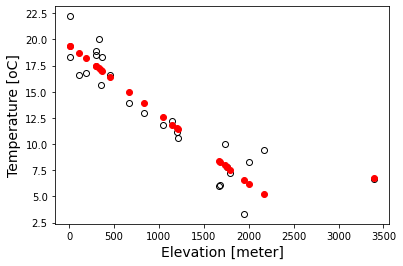

In [19]:
plt.plot(df3.iloc[2].values, df1.loc[Date].values, 'ko', mfc='none')

theta = pos.x
loo = LeaveOneOut()

X_ = X[indx]
y_ = y[indx]

u = []
v = []

for train_index, test_index in loo.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_[train_index], y_[test_index]


    N = X_train.shape[0]
    zp = theta[0]
    slope = theta[1]
    s2 = theta[2]

    y_model = slope*X_train[:,2]+zp
    ind, = np.where(X_train[:,2]>2150)
    y_model[ind] += s2*(X_train[:,2][ind]-2150)


    y_model_test = slope*X_test[:,2]+zp
    ind, = np.where(X_test[:,2]>2150)
    y_model_test[ind] += s2*(X_test[:,2][ind]-2150)    
    
    
    plt.plot(X_test[:,2], y_model_test , 'ro')
    
    u.append(y_model_test[0])
    v.append(y_test[0])
    
u = np.asarray(u)
v = np.asarray(v)

plt.xlabel("Elevation [meter]", fontsize=14)
plt.ylabel("Temperature [oC]", fontsize=14)

MAE: 1.46  RMSE: 1.80  R^2: 0.86


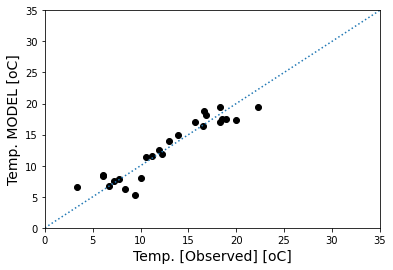

In [20]:
plt.plot(v, u, 'ko')

plt.xlim(0,35)
plt.ylim(0,35)

plt.plot([0,35], [0,35], ':')

plt.ylabel("Temp. MODEL [oC]", fontsize=14)
plt.xlabel("Temp. [Observed] [oC]", fontsize=14)

metrics(u, v)

In [21]:
# def XI2(theta):
    
# #         kf = KFold(n_splits=3)
#         loo = LeaveOneOut()
#         XI2 = 0
        
# #         for train_index, test_index in kf.split(X):
#         for train_index, test_index in loo.split(X):
#             X_train, X_test = X[train_index], X[test_index]
#             y_train, y_test = y[train_index], y[test_index]
        
        
#             N = X_train.shape[0]
            
#             zp = theta[0]
#             slope = theta[1]
#             s2 = theta[2]

#             y_model = slope*X_train[:,2]+zp
#             ind, = np.where(X_train[:,2]>2150)
#             y_model[ind] += s2*(X_train[:,2][ind]-2150)

            
#             y_model_test = slope*X_test[:,2]+zp
#             ind, = np.where(X_test[:,2]>2150)
#             y_model_test[ind] += s2*(X_test[:,2][ind]-2150)           
            
#             XI2 += np.sum((y_model_test - y_test)**2)
            
#         return XI2
    
    
    
# def Xi2_swarm(x):
  
#     nParticle = x.shape[0]
#     out = np.zeros(nParticle)

#     for n_iter in range(nParticle):
        
#         theta = x[n_iter,:]        
#         out[n_iter] = XI2(theta)  # to be minimzed

#     return out 

In [22]:
# %%time
# # Set-up hyperparameters
# options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# # Call instance of PSO
# optimizer = GlobalBestPSO(n_particles=1000, dimensions=3, options=options)

# # Perform optimization
# cost, pos = optimizer.optimize(Xi2_swarm, iters=500)

# print(pos)